In [1]:
#
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
import time
import ipywidgets

import discretize
from simpeg.electromagnetics import time_domain as tdem
from simpeg import maps

# solver 
from simpeg.utils.solver_utils import get_default_solver

In [3]:
Solver = get_default_solver()
Solver

pymatsolver.direct.mumps.Mumps

In [4]:
# conductivity values
rho_back = 500

sigma_target = 1e3
sigma_air = 1e-8
sigma_back = 1/rho_back

# target geometry
target_x = np.r_[-50, 50]
target_y = np.r_[-50, 50]
target_thickness = 20
target_z = -200 + target_thickness/2 * np.r_[-1, 1]

target_dip = 30

print(f"target conductances: {sigma_target * target_thickness}")

target conductances: 20000.0


In [5]:
# transmitter
tx_halfwidth = 45
tx_z = 0.5  # put slightly above the surface
tx_points = np.array([
    [-tx_halfwidth, -tx_halfwidth, tx_z],
    [ tx_halfwidth, -tx_halfwidth, tx_z],
    [ tx_halfwidth,  tx_halfwidth, tx_z],
    [-tx_halfwidth,  tx_halfwidth, tx_z],
    [-tx_halfwidth, -tx_halfwidth, tx_z],  # close the loop
])

# receiver times
rx_times = 1e-3 * np.logspace(-1, 1, 30)  # 30 time-channels between 0.1ms and 10ms
n_times = len(rx_times)

rx_x = np.linspace(-100, 100, 10)
rx_y = np.linspace(-100, 100, 10)
rx_z = np.r_[0]

rx_locs = discretize.utils.ndgrid(rx_x, rx_y, rx_z)

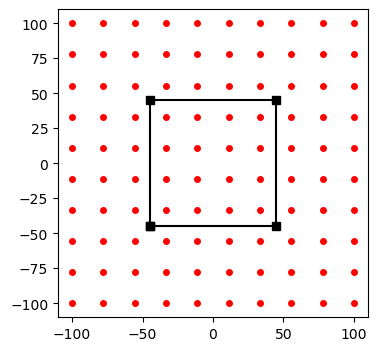

In [6]:
# quick check -- plot out our sources and receivers

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.plot(tx_points[:, 0], tx_points[:, 1], "-s", color="k")
ax.plot(rx_locs[:, 0], rx_locs[:, 1], "ro", ms=4)

ax.set_aspect = 1

In [7]:
def diffusion_distance(sigma, t):
    return 1260 * np.sqrt(t/sigma)

In [8]:
# minimum diffusion distance (max conductivity, earliest time) 
diffusion_distance(sigma_target, rx_times.min())

np.float64(0.3984469851812158)

In [9]:
# maximum diffusion distance (background conductivity, latest time)
diffusion_distance(sigma_back, rx_times.max())

np.float64(3984.469851812158)

In [22]:
base_cell_width = 5
domain_extent = 5000

n_base_cells = 2 ** int(
    np.ceil(np.log(domain_extent / base_cell_width) / np.log(2.0))
)  # needs to be powers of 2 for the tree mesh

h = [(base_cell_width, n_base_cells)]
mesh = discretize.TreeMesh([h, h, h], x0="CCC")

# refine near transmitters and receivers
mesh.refine_points(
    rx_locs, level=-1, padding_cells_by_level=[1, 2, 4], 
    finalize=False, diagonal_balance=True
)

# Refine core region of the mesh 
xyz = discretize.utils.ndgrid(
    [rx_x.min(), rx_x.max()], 
    [rx_y.min(), rx_y.max()], 
    [target_z.min() - base_cell_width * 4, 0.0]
)

bounding_points = np.array([
    [rx_x.min(), rx_y.min(), target_z.min() - base_cell_width * 4], 
    [rx_x.max(), rx_y.max(), 0],
])
mesh.refine_bounding_box(
    bounding_points, level=-1, 
    diagonal_balance=True, finalize=False
)

mesh.finalize()

In [23]:
mesh.n_cells

110916

In [24]:
def dipping_target_indices(mesh, target_x, target_y, target_z, dip): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*180/np.pi)
    
    z_bottom = (mesh.cell_centers[:, 0] - x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - x_center) * slope + target_z.max()

    return(
        (mesh.cell_centers[:, 0] >= target_x.min()) &
        (mesh.cell_centers[:, 0] <= target_x.max()) &
        (mesh.cell_centers[:, 1] >= target_y.min()) &
        (mesh.cell_centers[:, 1] <= target_y.max()) &
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

In [25]:
model_background = sigma_air * np.ones(mesh.n_cells)
model_background[mesh.cell_centers[:, 2] < 0] = sigma_back

model_target = model_background.copy()
inds_target = dipping_target_indices(mesh, target_x, target_y, target_z, target_dip)
model_target[inds_target] = sigma_target

models = {
    "background": model_background,
    "target": model_target
}

(-500.0, 50.0)

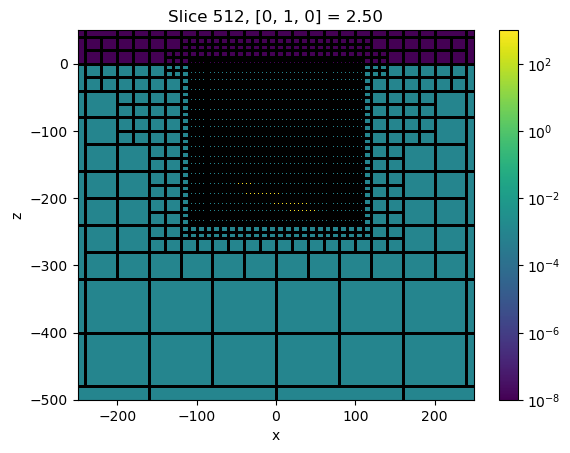

In [26]:
fig, ax = plt.subplots(1, 1) 

plt.colorbar(
    mesh.plot_slice(
        models["target"], 
        grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm()},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(np.r_[-250, 250])
ax.set_ylim(np.r_[-500, 50])

# Survey

In [27]:
dbdt_receivers = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        locations=rx_locs, times=rx_times, orientation=orientation
    )
    for orientation in ["x", "y", "z"]
]

In [28]:
waveform=tdem.sources.StepOffWaveform()
src = tdem.sources.LineCurrent(
    receiver_list=dbdt_receivers, location=tx_points, 
    waveform=waveform, srcType="inductive"
)

survey = tdem.Survey([src])

In [29]:
nsteps = 20
time_steps = [
    (1e-5, nsteps), (3e-5, nsteps), (1e-4, nsteps), (3e-4, nsteps+10)
]

In [30]:
simulation = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey, time_steps=time_steps, solver=Solver,
    sigmaMap=maps.IdentityMap(mesh)
)

In [31]:
fields = {}
dpred = {}

for key, val in models.items():
    t = time.time()
    fields[key] = simulation.fields(val)
    dpred[key] = simulation.make_synthetic_data(val, f=fields[key])
    print(f"done {key}... {time.time() - t: 1.2e}s")

done background...  6.46e+01s
done target...  6.43e+01s


In [46]:
def plot_2D_data(plot_key, tind, subtract=None, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))
        
    for i, rx in enumerate(dbdt_receivers):
        src = survey.source_list[0]
        dpred_plot = dpred[plot_key][src, rx].reshape(len(rx_locs), len(rx_times), order="F")

        if subtract is not None: 
            dpred_background = dpred[subtract][src, rx][tind*len(rx_locs):(tind+1)*len(rx_locs)]
            dpred_plot = dpred_plot[:, tind] - 
        plt.colorbar(
            ax[i].scatter(
                rx_locs[:, 0], rx_locs[:, 1], 
                c=dpred_plot, cmap="Spectral_r",
                s=30
            ), ax=ax[i]
        )
        ax[i].set_aspect(1)

    if subtract is None: 
        plot_label = plot_key
    else:
        plot_label = f"{plot_key} - {subtract}"
        
    ax[1].set_title(f"{plot_label}, db/dt, \n t={rx_times[tind]*1e3:1.1e}ms \n")

    return ax

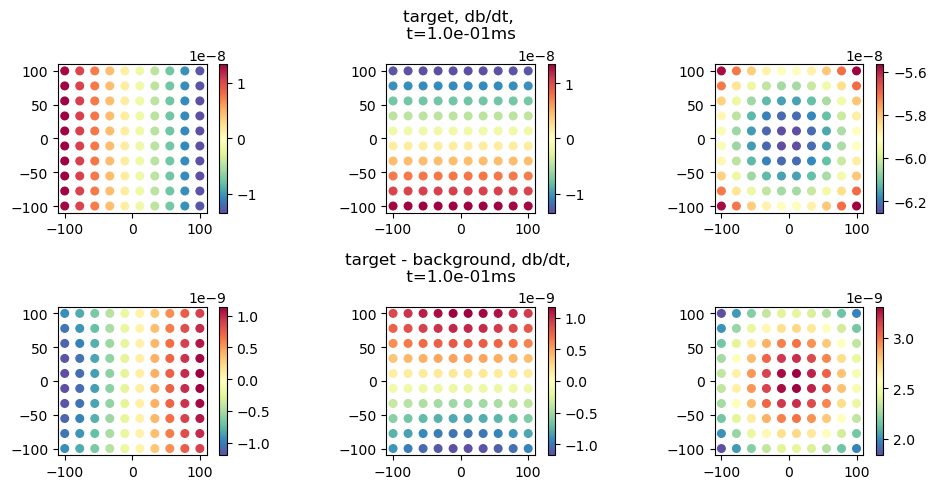

In [92]:
tind_plot = 0 #[0, 10, 20, 29]

fig, ax = plt.subplots(2, 3, figsize=(10, 5))
 
plot_2D_data("target", tind_plot, ax=ax[0, :])
plot_2D_data("target", tind_plot, subtract="background", ax=ax[1, :])

plt.tight_layout()

In [114]:
val[src, rx].shape

(3000,)

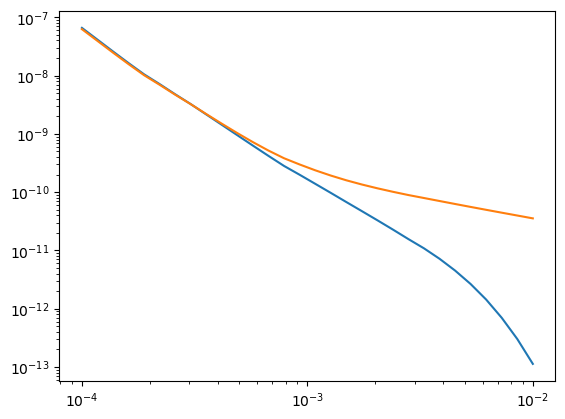

In [115]:
# look at data for a single point
location_plot = np.r_[0, 0, 0]

ind_plot = np.argmin(np.linalg.norm(rx_locs - location_plot, axis=1))

fig, ax = plt.subplots(1, 1) 

for key, val in dpred.items():
    src = val.survey.source_list[0]
    rx = src.receiver_list[-1]  # grab the z-component
    dpred_plot = val[src, rx].reshape(len(rx_locs), len(rx_times), order="F")
    ax.loglog(rx_times, -dpred_plot[ind_plot, :], label=key)

In [80]:
def plot_current_density(
    key, ti, ax=None, xlim=400*np.r_[-1, 1], zlim=np.r_[-500, 80],
    colorbar=False, ylabels=True, vmax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    jplt = mesh.average_edge_to_cell_vector * np.squeeze(fields[key][:, "j", ti])
    
    if vmax is not None: 
        pcolor_opts={"norm":Normalize(vmin=-vmax, vmax=vmax), "cmap":"coolwarm"}
    else: 
        pcolor_opts = {"cmap":"coolwarm"}
        
    out = mesh.plot_slice(
        jplt[mesh.n_cells:mesh.n_cells*2], 
        ax=ax, 
        pcolor_opts=pcolor_opts,
        normal="Y", 
    )

    
    
    ax.plot(tx_points[:, 0], tx_points[:, 2], "ko", ms=2)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    
    if colorbar is True: 
        cb = plt.colorbar(out[0], ax=ax, orientation="horizontal")
        cb.set_label("current density")
    
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")

    return ax

<Axes: title={'center': 'Slice 512, [0, 1, 0] = 2.50'}, xlabel='x', ylabel='z'>

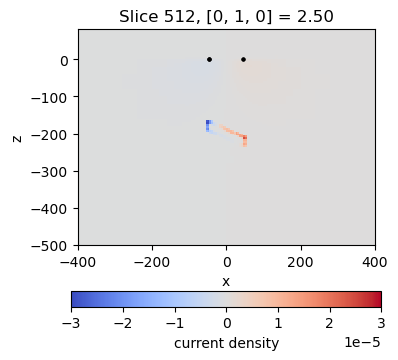

In [90]:
plot_current_density("target", 2, colorbar=True, vmax=3e-5)

In [172]:
def plot_dbdt(
    key, ti, ax=None, xlim=400*np.r_[-1, 1], zlim=np.r_[-500, 80],
    colorbar=False, ylabels=True, vmax=1e-5, vmin=1e-13
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    dbdtplt = mesh.average_face_to_cell_vector * np.squeeze(fields[key][:, "dbdt", ti])
    out = mesh.plot_slice(
        dbdtplt.reshape(mesh.n_cells, 3, order="F"), 
        "CCv", view="vec", 
        ax=ax, 
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)},
        # range_x=xlim, 
        # range_y=zlim,
        stream_threshold=vmin,
        normal="y"
    )
    # ax.plot(np.r_[0], tx_height, "ko", ms=2)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")
    if colorbar is True: 
        cb = plt.colorbar(out[0][0], ax=ax, orientation="horizontal")
        cb.set_label("db/dt")
    return ax

In [173]:
key="background"
ti = 0
dbdtplt = mesh.average_face_to_cell_vector * np.squeeze(fields[key][:, "dbdt", ti])

<Axes: title={'center': 'Slice 512, [0, 1, 0] = 2.50'}, xlabel='x', ylabel='z'>

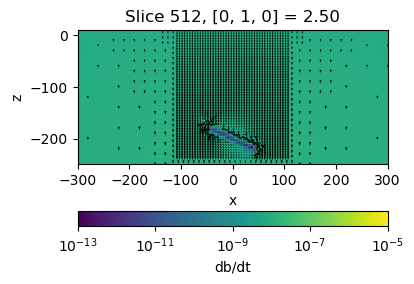

In [174]:
plot_dbdt("target", 20, colorbar=True, xlim=300*np.r_[-1, 1], zlim=np.r_[-250, 10])